In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --------- STEP 1: Load viral read IDs ---------
def extract_viral_and_chimeric(filepath):
    viral_reads = set()
    chimeric_reads = set()
    
    with open(filepath) as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 3:
                read_id = parts[0]
                status = parts[2].strip().lower()
                viral_reads.add(read_id)
                if status == "chimeric":
                    chimeric_reads.add(read_id)
    return viral_reads, chimeric_reads

true_viral_reads, chimeric_viral_reads = extract_viral_and_chimeric("200K_virus_reads_chimeric.tsv")

# --------- STEP 2: Load classifier outputs ---------

# CENTRIFUGER
centrifuger_df = pd.read_csv("1st_classification_results/centrifuger/full_sim_om_200000report.tsv", sep="\t")
centrifuger_classified = set(centrifuger_df.loc[centrifuger_df['seqID'] != "unclassified", 'readID'])

# DIAMOND + MEGAN
diamond_df = pd.read_csv("1st_classification_results/diamond-megan/full_sim_om_200000_classification.tsv", sep="\t", header=None, names=["readID", "taxID"])
diamond_classified = set(diamond_df['readID'])

# KRAKEN2
kraken_classified = set()
with open("1st_classification_results/kraken2/full_sim_om_200000.kraken2.out") as f:
    for line in f:
        parts = line.strip().split("\t")
        if parts[0] == "C":
            kraken_classified.add(parts[1])

# --------- STEP 3: Build summary DataFrame ---------
all_reads = true_viral_reads | centrifuger_classified | diamond_classified | kraken_classified

df = pd.DataFrame({
    'readID': list(all_reads)
})
df['is_viral'] = df['readID'].isin(true_viral_reads)
df['is_chimeric'] = df['readID'].isin(chimeric_viral_reads)
df['centrifuger_viralDB'] = df['readID'].isin(centrifuger_classified)
df['diamond_megan_viralDB'] = df['readID'].isin(diamond_classified)
df['kraken2_viralDB'] = df['readID'].isin(kraken_classified)

# Save the summary
df.to_csv("classification_summary.tsv", sep="\t", index=False)
print("Classification_summary.tsv saved!")
df

Classification_summary.tsv saved!


,readID,is_viral,is_chimeric,centrifuger_viralDB,diamond_megan_viralDB,kraken2_viralDB
0,Segatella_copri-NZ-CP156893_86042_aligned_1264...,False,False,False,True,False
1,Swine_Influenza_A_Virus_(IAV-S)-NC-026433_101;...,True,True,True,True,True
2,Suid_betaherpesvirus_2-NC-022233_3400;gap_18;B...,True,True,True,True,True
3,Suid_betaherpesvirus_2-NC-022233_102118_aligne...,True,False,True,False,True
4,Jeotgalicoccus_sp._ATCC_8456-NZ-CP066224_19251...,False,False,False,True,False
...,...,...,...,...,...,...
8865,Segatella_copri-NZ-CP156893_108450;gap_25;Suid...,True,True,True,True,True
8866,Suid_betaherpesvirus_2-NC-022233_56298;gap_92;...,True,True,True,True,True
8867,Dorea_formicigenerans-NZ-CP173381_2392763;gap_...,True,True,True,True,True
8868,Fusobacterium_necrophorum-NZ-CP169222_36568;ga...,True,True,True,True,True


In [ ]:

# ---------- Load fullDB reports with lineage ----------
centrifuge_full = pd.read_csv(
    "1st_classification_results/centrifuge_fullDB/full_sim_om_200000.centrifuge_withLineage.out.tsv",
    sep="\t", names=["lineage","taxID", "readID"]
)

diamond_full = pd.read_csv(
    "1st_classification_results/diamond-megan_fullDB/full_sim_om_200000_withLineage.out",
    sep="\t", names=["lineage","taxID", "readID"]
)

kraken_full = pd.read_csv(
    "1st_classification_results/kraken_fullDB/full_sim_om_200000.kraken2_withLineage.out",
    sep="\t", names=["lineage","taxID", "readID"]
)

# ---------- Filter only reads with "Viruses" in the lineage ----------
centrifuge_viral = centrifuge_full[centrifuge_full['lineage'].str.contains("Viruses", case=False, na=False)]
diamond_viral = diamond_full[diamond_full['lineage'].str.contains("Viruses", case=False, na=False)]
kraken_viral = kraken_full[kraken_full['lineage'].str.contains("Viruses", case=False, na=False)]

# ---------- Mark reads in df ----------
df['centrifuge_fullDB'] = df['readID'].isin(set(centrifuge_viral['readID']))
df['diamond-megan_fullDB'] = df['readID'].isin(set(diamond_viral['readID']))
df['kraken2_fullDB'] = df['readID'].isin(set(kraken_viral['readID']))

# ---------- Save result ----------
df.to_csv("classification_summary_with_fullDB.tsv", sep="\t", index=False)
print("classification_summary_with_fullDB.tsv saved (only viral hits from full DB included).")

# Optional: preview
df.head()

✅ classification_summary_with_fullDB.tsv saved (only viral hits from full DB included).


,readID,is_viral,is_chimeric,centrifuger_viralDB,diamond_megan_viralDB,kraken2_viralDB,centrifuge_fullDB,diamond-megan_fullDB,kraken2_fullDB
0,Segatella_copri-NZ-CP156893_86042_aligned_1264...,False,False,False,True,False,False,False,False
1,Swine_Influenza_A_Virus_(IAV-S)-NC-026433_101;...,True,True,True,True,True,True,True,True
2,Suid_betaherpesvirus_2-NC-022233_3400;gap_18;B...,True,True,True,True,True,True,True,True
3,Suid_betaherpesvirus_2-NC-022233_102118_aligne...,True,False,True,False,True,True,False,True
4,Jeotgalicoccus_sp._ATCC_8456-NZ-CP066224_19251...,False,False,False,True,False,False,False,False


/var/folders/_p/cpx_rt5n0bl5d6v6kpzddqrc0000gn/T/ipykernel_47251/2493789577.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sens_df, x='Recovered %', y='Tool', palette=colors)


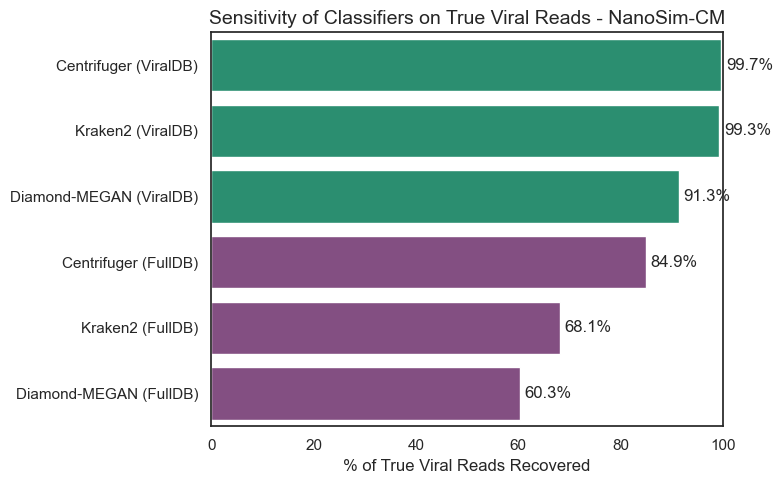

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Tool labels and custom colors ---------
tools = [
    ('centrifuger_viralDB', 'Centrifuger (ViralDB)'),
    ('diamond_megan_viralDB', 'Diamond-MEGAN (ViralDB)'),
    ('kraken2_viralDB', 'Kraken2 (ViralDB)'),
    ('centrifuge_fullDB', 'Centrifuger (FullDB)'),
    ('diamond-megan_fullDB', 'Diamond-MEGAN (FullDB)'),
    ('kraken2_fullDB', 'Kraken2 (FullDB)')
]

colors = [
    '#1b9e77', '#1b9e77', '#1b9e77',  # green for ViralDB tools
    "#8c468ade","#8c468ade", "#8c468ade"   # color for FullDB tools
]

# --------- Sensitivity Calculation ---------
sensitivity = []
total_viral_reads = df['is_viral'].sum()

for col, label in tools:
    recovered = df[(df['is_viral']) & (df[col])].shape[0]
    pct = recovered / total_viral_reads * 100
    sensitivity.append({'Tool': label, 'Recovered %': pct})

sens_df = pd.DataFrame(sensitivity)
sens_df.sort_values('Recovered %', ascending=False, inplace=True)

# --------- Plotting ---------
sns.set(style="white")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=sens_df, x='Recovered %', y='Tool', palette=colors)

# Annotate bars
for i, val in enumerate(sens_df['Recovered %']):
    ax.text(val + 1, i, f'{val:.1f}%', va='center')
    
plt.xlim(0, 100)
plt.title('Sensitivity of Classifiers on True Viral Reads - NanoSim-CM', fontsize=14)
plt.xlabel('% of True Viral Reads Recovered')
plt.ylabel('')
plt.tight_layout()
plt.savefig("sensitivity_comparison_colored.png", dpi=300)
plt.show()


/var/folders/_p/cpx_rt5n0bl5d6v6kpzddqrc0000gn/T/ipykernel_47251/1612684601.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sens_df, x='Recovered %', y='Tool', palette='plasma')


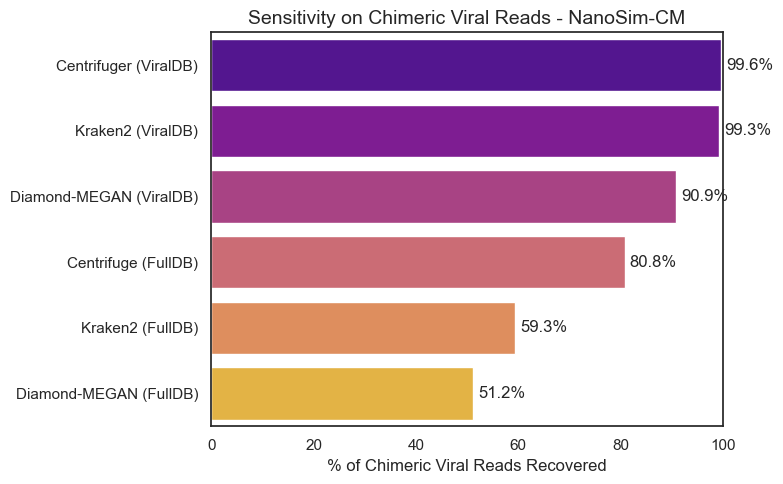

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Make sure you have this column ---
# df['is_chimeric'] = df['readID'].isin(set_of_chimeric_read_ids)

# Define tool columns and prettier labels
tools = [
    ('centrifuger_viralDB', 'Centrifuger (ViralDB)'),
    ('diamond_megan_viralDB', 'Diamond-MEGAN (ViralDB)'),
    ('kraken2_viralDB', 'Kraken2 (ViralDB)'),
    ('centrifuge_fullDB', 'Centrifuge (FullDB)'),
    ('diamond-megan_fullDB', 'Diamond-MEGAN (FullDB)'),
    ('kraken2_fullDB', 'Kraken2 (FullDB)')
]

sensitivity = []

# Filter for chimeric + viral reads
chimeric_viral_df = df[(df['is_viral']) & (df['is_chimeric'])]
total_chimeric_viral = chimeric_viral_df.shape[0]

for col, label in tools:
    recovered = chimeric_viral_df[chimeric_viral_df[col]].shape[0]
    pct = recovered / total_chimeric_viral * 100 if total_chimeric_viral > 0 else 0
    sensitivity.append({'Tool': label, 'Recovered %': pct})

# Create DataFrame
sens_df = pd.DataFrame(sensitivity)
sens_df.sort_values('Recovered %', ascending=False, inplace=True)

# Plot
sns.set(style="white")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=sens_df, x='Recovered %', y='Tool', palette='plasma')

# Annotate bars
for i, val in enumerate(sens_df['Recovered %']):
    ax.text(val + 1, i, f'{val:.1f}%', va='center')

plt.xlim(0, 100)
plt.title('Sensitivity on Chimeric Viral Reads - NanoSim-CM', fontsize=14)
plt.xlabel('% of Chimeric Viral Reads Recovered')
plt.ylabel('')
plt.tight_layout()
plt.savefig("sensitivity_chimeric_viral_reads.png", dpi=300)
plt.show()
